# 1. Environment Setup and Data Unpacking

This initial section handles the crucial setup steps for the Colab environment. The process is organized as follows:

1.  **Configuration**: Key paths and filenames are defined as variables at the top for easy modification and clarity.
2.  **Mount Google Drive**: The Colab environment is connected to the user's Google Drive to access the project's data archive.
3.  **Unpack Dataset**: The data (`.zip` archive) is located on Drive and then unpacked into the local Colab filesystem for improved performance during analysis and training.

In [1]:
import os
from google.colab import drive

# --- 1. Configuration ---
# Define all necessary paths and filenames here.
GDRIVE_PROJECT_PATH = "/content/drive/MyDrive/EgoVisionProject/Data" # Main project folder on Google Drive
ZIP_FILE_NAME    = "ego4d_data.zip"
LOCAL_DATA_PATH  = "/content/data" # Local temporary workspace in Colab

print("Configuration set.")

# --- 2. Mount Google Drive ---
print("Connecting to Google Drive...")
drive.mount('/content/drive', force_remount=True)
print("Drive connected.")

# --- 3. Unpack the Dataset ---
gdrive_zip_file = os.path.join(GDRIVE_PROJECT_PATH, ZIP_FILE_NAME)
print(f"\nLooking for dataset archive at: {gdrive_zip_file}")

if os.path.exists(gdrive_zip_file):
    print("Dataset archive found. Unpacking to local storage...")
    os.makedirs(LOCAL_DATA_PATH, exist_ok=True)

    # Unzip directly from Drive to the local path.
    # -o flag overwrites files without asking, -q flag for quiet mode.
    !unzip -o -q "{gdrive_zip_file}" -d "{LOCAL_DATA_PATH}"
    print("Unpacking complete.")

    # Verification Step
    print("\n--- Verifying contents of the annotations directory: ---")
    !ls -lH "{LOCAL_DATA_PATH}/ego4d_data/v1/annotations"
    print("---------------------------------------------------------")
else:
    print(f"ERROR: Dataset archive not found at '{gdrive_zip_file}'. Please check the path.")

Configuration set.
Connecting to Google Drive...
Mounted at /content/drive
Drive connected.

Looking for dataset archive at: /content/drive/MyDrive/EgoVisionProject/Data/ego4d_data.zip
Dataset archive found. Unpacking to local storage...
Unpacking complete.

--- Verifying contents of the annotations directory: ---
total 2628952
-rw-rw-rw- 1 root root      77019 May  7 13:02 av_test_unannotated.json
-rw-rw-rw- 1 root root  632336417 May  7 13:02 av_train.json
-rw-rw-rw- 1 root root   59129336 May  7 13:02 av_val.json
-rw-rw-rw- 1 root root    6418699 May  7 13:01 fho_hands_test_unannotated.json
-rw-rw-rw- 1 root root   68639174 May  7 13:02 fho_hands_train.json
-rw-rw-rw- 1 root root   45460459 May  7 13:02 fho_hands_val.json
-rw-rw-rw- 1 root root      12113 May  7 13:02 fho_lta_taxonomy.json
-rw-rw-rw- 1 root root   10447110 May  7 13:01 fho_lta_test_unannotated.json
-rw-rw-rw- 1 root root   18234337 May  7 13:01 fho_lta_train.json
-rw-rw-rw- 1 root root   12052154 May  7 13:01 fho_lt

## 2. Load Annotations and Prepare DataFrame

This section is dedicated to loading the raw annotation files (`nlq_train.json` and `nlq_val.json`) from the local storage. We define a helper function to parse the nested JSON structure and flatten it into a clean `pandas` DataFrame. To ensure our analysis is comprehensive, we process both the training and validation splits and concatenate them into a single `full_df` DataFrame.

In [2]:
import json
import pandas as pd
import os

#Parses a NLQ JSON file and converts it into a pandas DataFrame.
def parse_nlq_to_dataframe(file_path):
    all_queries = []
    with open(file_path, 'r') as f:
        nlq_data = json.load(f)

    for video in nlq_data.get('videos', []):
        for clip in video.get('clips', []):
            clip_duration = clip.get('video_end_sec', 0) - clip.get('video_start_sec', 0)
            for annotation in clip.get('annotations', []):
                for query in annotation.get('language_queries', []):
                    query['video_uid'] = video['video_uid']
                    query['clip_uid'] = clip['clip_uid']
                    query['clip_duration_sec'] = clip_duration
                    query['answer_duration_sec'] = query.get('video_end_sec', 0) - query.get('video_start_sec', 0)
                    all_queries.append(query)
    return pd.DataFrame(all_queries)

# --- Main execution ---
train_file = os.path.join(LOCAL_DATA_PATH, 'ego4d_data/v1/annotations/nlq_train.json')
val_file = os.path.join(LOCAL_DATA_PATH, 'ego4d_data/v1/annotations/nlq_val.json')

try:
    print("Parsing training and validation splits...")
    train_df = parse_nlq_to_dataframe(train_file)
    val_df = parse_nlq_to_dataframe(val_file)

    # Combine both dataframes for a full analysis
    full_df = pd.concat([train_df, val_df], ignore_index=True)

    print(f"\nSuccessfully created DataFrame with {len(full_df)} total queries.")
    print("Displaying the first 5 rows of the combined DataFrame:")
    display(full_df.head())

except FileNotFoundError as e:
    print(f"ERROR: Annotation file not found.")
    print(f"Details: {e}")
    print("Please make sure Cell 1 was executed successfully.")

Parsing training and validation splits...

Successfully created DataFrame with 15171 total queries.
Displaying the first 5 rows of the combined DataFrame:


,clip_start_sec,clip_end_sec,video_start_sec,video_end_sec,video_start_frame,video_end_frame,template,query,slot_x,verb_x,slot_y,verb_y,raw_tags,video_uid,clip_uid,clip_duration_sec,answer_duration_sec
0,0.00000,43.6657,0.021029,43.686729,1,1311,Objects: How many X’s? (quantity question),How many frying pans can i see on the shelf?,frying pans,[verb_not_applicable],i See on the shelf,see,"[Objects: How many X’s? (quantity question), H...",d250521e-5197-44aa-8baa-2f42b24444d2,fae92e70-88aa-4b77-b41a-5879b74c804c,480.0,43.66570
1,55.80900,60.2600,55.830029,60.281029,1675,1809,Objects: What X did I Y?,What colour bowl did i carry from the plate st...,colour bowl,[verb_not_applicable],I Carry from the plate stand,carry,"[Objects: What X did I Y?, What colour bowl di...",d250521e-5197-44aa-8baa-2f42b24444d2,fae92e70-88aa-4b77-b41a-5879b74c804c,480.0,4.45100
2,62.70855,72.2100,62.729579,72.231029,1882,2167,Objects: In what location did I see object X ?,In what location did i see the basket?,i See the basket,see,NaN,NaN,[Objects: In what location did I see object X ...,d250521e-5197-44aa-8baa-2f42b24444d2,fae92e70-88aa-4b77-b41a-5879b74c804c,480.0,9.50145
3,150.49668,154.4890,150.517709,154.510029,4516,4636,Objects: What did I put in X?,What did i pour in the bowl?,I Pour in the bowl,pour,NaN,NaN,"[Objects: What did I put in X?, What did i pou...",d250521e-5197-44aa-8baa-2f42b24444d2,fae92e70-88aa-4b77-b41a-5879b74c804c,480.0,3.99232
4,7.16000,8.5180,7.181029,8.539029,216,257,Objects: Where is object X before / after even...,Where was the soap before i picked it up?,soap,[verb_not_applicable],i picked it up,pick,[Objects: Where is object X before / after eve...,d250521e-5197-44aa-8baa-2f42b24444d2,fae92e70-88aa-4b77-b41a-5879b74c804c,480.0,1.35800


## 3. EDA - Query Template Distribution

As a first step in our exploratory data analysis, we investigate the composition of the dataset by analyzing the distribution of query templates. The Ego4D-NLQ benchmark defines 13 query templates across three main categories (Objects, Place, People). By visualizing these counts, we can gain insight into which types of questions are most prevalent, which can inform our modeling and data augmentation strategies.

<ipython-input-3-2725176183>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


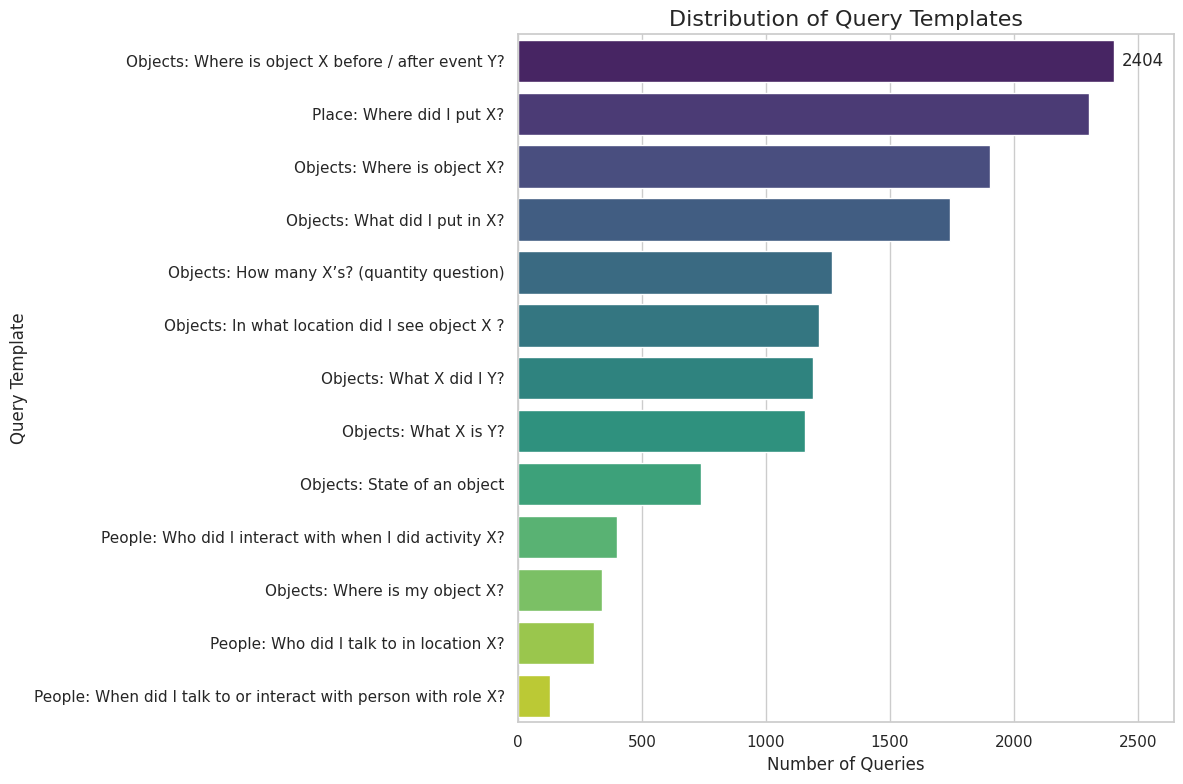


Query counts per template:
template
Objects: Where is object X before / after event Y?                 2404
Place: Where did I put X?                                          2302
Objects: Where is object X?                                        1902
Objects: What did I put in X?                                      1740
Objects: How many X’s? (quantity question)                         1267
Objects: In what location did I see object X ?                     1215
Objects: What X did I Y?                                           1190
Objects: What X is Y?                                              1159
Objects: State of an object                                         737
People: Who did I interact with when I did activity X?              401
Objects: Where is my object X?                                      338
People: Who did I talk to in location X?                            307
People: When did I talk to or interact with person with role X?     128
Name: count, dtype: int64


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the DataFrame from the previous cell exists
if 'full_df' in locals():
    # Set plot style and figure size
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 8))

    # --- Plotting the distribution ---
    ax = sns.countplot(
        y='template',
        data=full_df,
        order=full_df['template'].value_counts().index, # Order bars from most to least frequent
        palette="viridis"
    )

    # Add count labels to the end of each bar for clarity
    ax.bar_label(ax.containers[0], padding=5)

    plt.title('Distribution of Query Templates', fontsize=16)
    plt.xlabel('Number of Queries', fontsize=12)
    plt.ylabel('Query Template', fontsize=12)

    # Set a dynamic x-limit to give labels enough space
    plt.xlim(0, full_df['template'].value_counts().max() * 1.1)

    plt.tight_layout()
    plt.show()

    # Also print the exact counts
    print("\nQuery counts per template:")
    print(full_df['template'].value_counts())
else:
    print("ERROR: DataFrame 'full_df' not found. Please run Cell 2 first.")

## 4. EDA - Analysis of Clip and Answer Durations

To understand the temporal characteristics of the task, we visualize the distributions of both the input clip durations and the ground-truth answer durations. This side-by-side comparison, consistent with the original analysis, helps to contextualize the problem's difficulty. It highlights the relationship between the total length of the video context the model must process and the specific duration of the event it needs to localize.

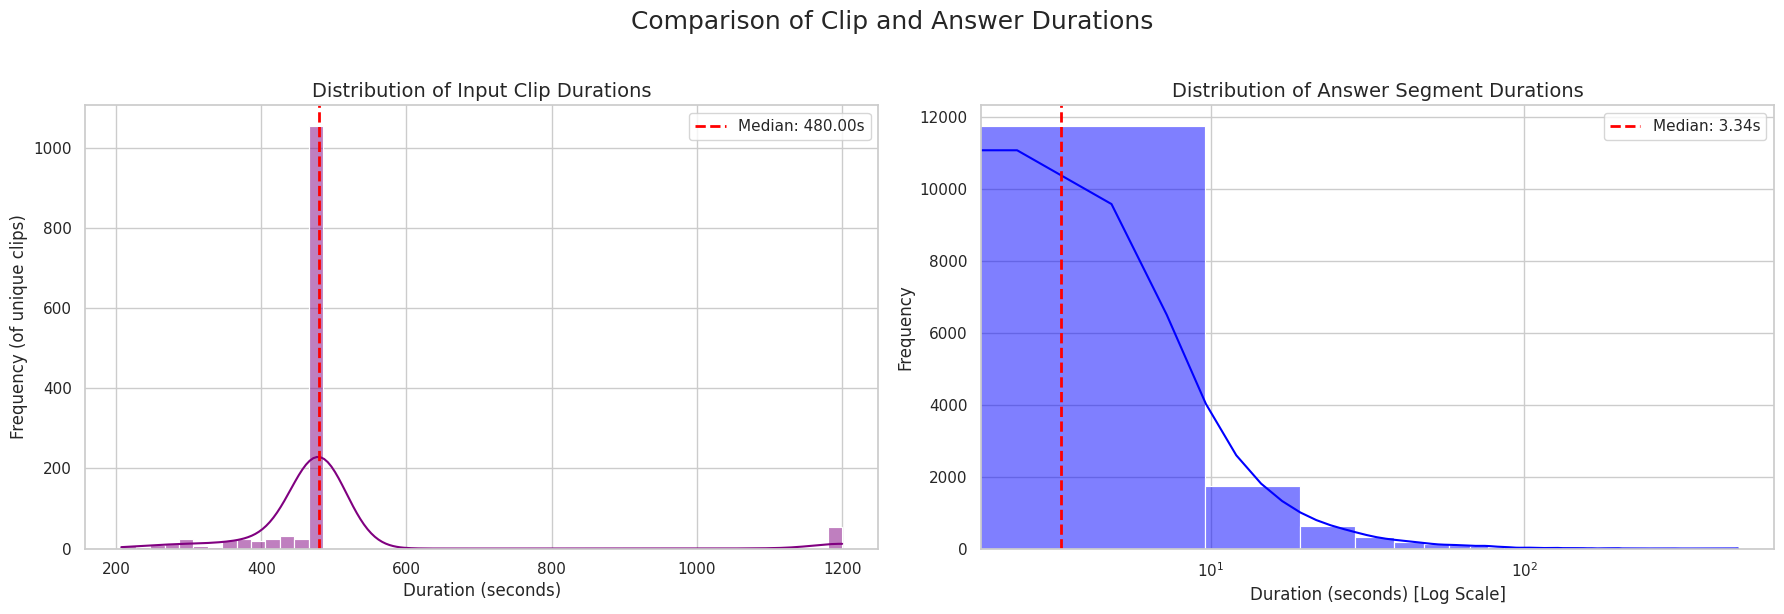


Statistics for Input Clip Durations (in seconds):


,clip_duration_sec
count,1326.000000
mean,495.045471
std,160.416373
min,207.166667
25%,480.000000
50%,480.000000
75%,480.036349
max,1200.066642



Statistics for Answer Segment Durations (in seconds):


,answer_duration_sec
count,15171.000000
mean,9.508745
std,22.683604
min,0.000000
25%,1.426510
50%,3.338920
75%,8.494965
max,480.000000


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure the DataFrame from the previous cells exists
if 'full_df' in locals():
    # Set plot style
    sns.set_theme(style="whitegrid")

    # Create a figure with two subplots side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # --- Plot 1 (Left): Input Clip Durations ---
    # To get a true distribution of clip durations, we first need to look at unique clips.
    unique_clips_df = full_df.drop_duplicates(subset=['clip_uid'])

    sns.histplot(data=unique_clips_df, x='clip_duration_sec', bins=50, kde=True, color='purple', ax=axes[0])
    axes[0].set_title('Distribution of Input Clip Durations', fontsize=14)
    axes[0].set_xlabel('Duration (seconds)', fontsize=12)
    axes[0].set_ylabel('Frequency (of unique clips)', fontsize=12)
    median_clip_duration = unique_clips_df['clip_duration_sec'].median()
    axes[0].axvline(median_clip_duration, color='red', linestyle='--', linewidth=2, label=f'Median: {median_clip_duration:.2f}s')
    axes[0].legend()

    # --- Plot 2 (Right): Answer Segment Durations ---
    sns.histplot(data=full_df, x='answer_duration_sec', bins=50, kde=True, color='blue', ax=axes[1])
    axes[1].set_title('Distribution of Answer Segment Durations', fontsize=14)
    axes[1].set_xlabel('Duration (seconds) [Log Scale]', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)

    # Apply log scale to see the distribution shape
    axes[1].set_xscale('log')
    median_answer_duration = full_df['answer_duration_sec'].median()
    axes[1].axvline(median_answer_duration, color='red', linestyle='--', linewidth=2, label=f'Median: {median_answer_duration:.2f}s')
    axes[1].legend()

    # --- Final Touches ---
    plt.suptitle('Comparison of Clip and Answer Durations', fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()

    # Display key statistics for both distributions for the final report
    print("\nStatistics for Input Clip Durations (in seconds):")
    display(unique_clips_df['clip_duration_sec'].describe())
    print("\nStatistics for Answer Segment Durations (in seconds):")
    display(full_df['answer_duration_sec'].describe())
else:
    print("ERROR: DataFrame 'full_df' not found. Please run the previous cells first.")

## 5. EDA - Detailed Scenario Analysis

This final analysis provides a detailed breakdown of the query template distribution within each of the top 5 most common scenarios. To enhance readability, template and scenario names are abbreviated. The data is normalized within each scenario to show the percentage of each template, rather than raw counts.

The result is visualized as a grid of horizontal bar charts, where each chart represents a single scenario and displays its unique template distribution. This method allows for a clear, comparative view of how the nature of queries changes depending on the real-world context.

<ipython-input-6-4018856539>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scenario_data.values, y=scenario_data.index, ax=ax, palette='viridis', orient='h')
<ipython-input-6-4018856539>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scenario_data.values, y=scenario_data.index, ax=ax, palette='viridis', orient='h')
<ipython-input-6-4018856539>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scenario_data.values, y=scenario_data.index, ax=ax, palette='viridis', orient='h')
<ipython-input-6-4018856539>:60: FutureWarning: 

Passi

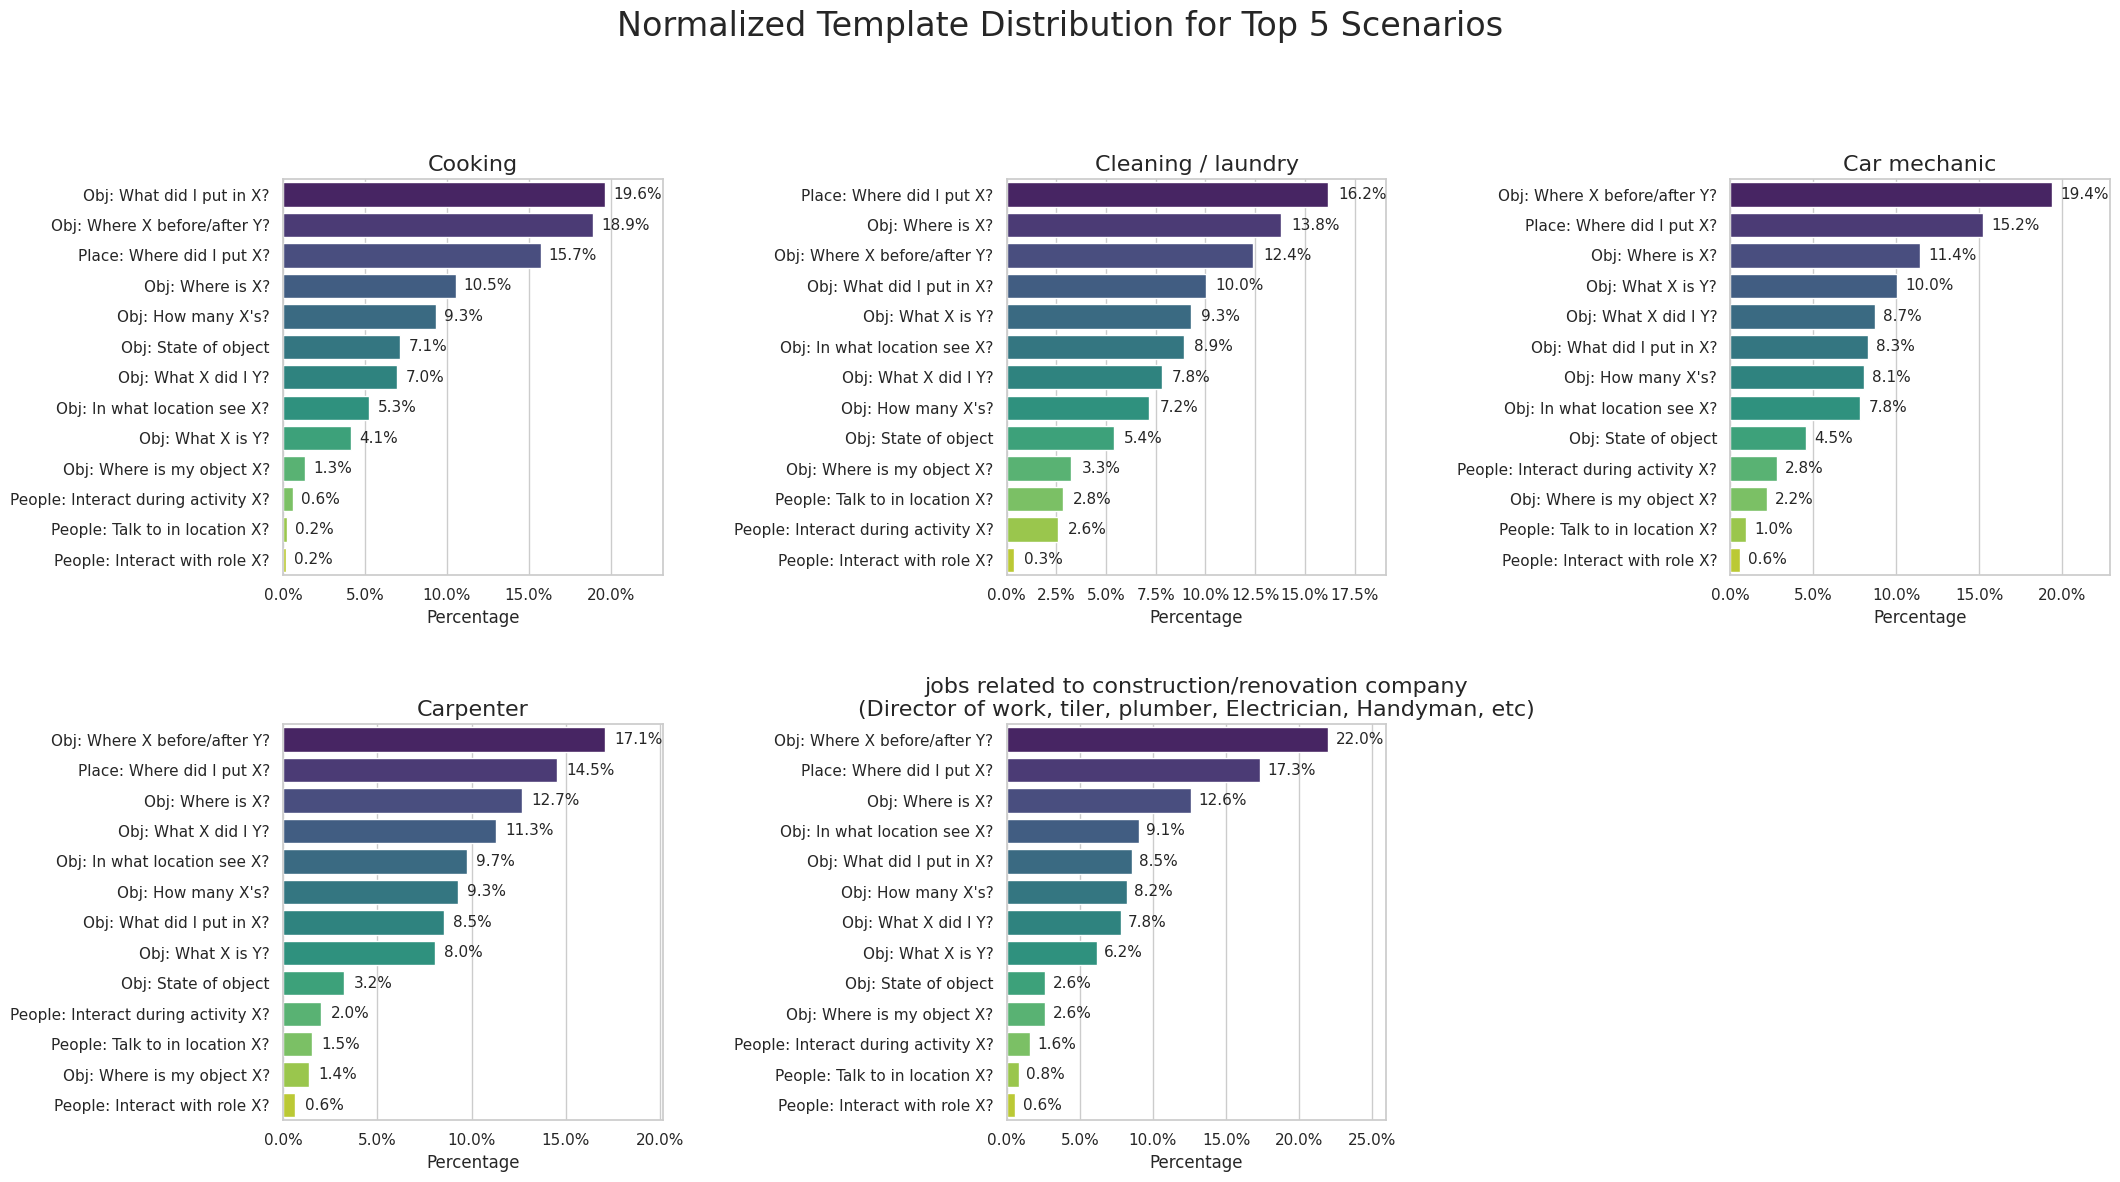

In [6]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

if 'full_df' in locals():
    try:
        # --- 1. Load ego4d.json and map scenarios ---
        ego4d_path = os.path.join(LOCAL_DATA_PATH, 'ego4d_data/ego4d.json')
        with open(ego4d_path, 'r') as f:
            ego4d_data = json.load(f)

        video_to_scenario = {}
        for video_info in ego4d_data.get("videos", []):
            if "scenarios" in video_info and video_info["scenarios"]:
                video_to_scenario[video_info["video_uid"]] = video_info["scenarios"][0]

        full_df['scenario'] = full_df['video_uid'].map(video_to_scenario)
        full_df_scenario = full_df.dropna(subset=['scenario']).copy()

        # --- 2. Abbreviate Template & Scenario Labels for Readability ---
        template_map = {
            'Objects: Where is object X before / after event Y?': 'Obj: Where X before/after Y?',
            'Place: Where did I put X?': 'Place: Where did I put X?',
            'Objects: Where is object X?': 'Obj: Where is X?',
            'Objects: What did I put in X?': 'Obj: What did I put in X?',
            "Objects: How many X’s? (quantity question)": "Obj: How many X's?",
            'Objects: In what location did I see object X ?': 'Obj: In what location see X?',
            'Objects: What X did I Y?': 'Obj: What X did I Y?',
            'Objects: What X is Y?': 'Obj: What X is Y?',
            'Objects: State of an object': 'Obj: State of object',
            'People: Who did I interact with when I did activity X?': 'People: Interact during activity X?',
            'Objects: Where is my object X?': 'Obj: Where is my object X?',
            'People: Who did I talk to in location X?': 'People: Talk to in location X?',
            'People: When did I talk to or interact with person with role X?': 'People: Interact with role X?'
        }
        full_df_scenario['short_template'] = full_df_scenario['template'].map(template_map)

        scenario_rename_map = {
            'jobs related to construction/renovation company (Director of work, tiler, plumber, Electrician, Handyman, etc)': 'Construction/Renovation'
        }
        full_df_scenario['scenario'] = full_df_scenario['scenario'].replace(scenario_rename_map)

        # --- 3. Prepare Data for Plotting ---
        contingency_table = pd.crosstab(full_df_scenario['scenario'], full_df_scenario['short_template'])
        top_scenarios = contingency_table.sum(axis=1).nlargest(5).index
        filtered_table = contingency_table.loc[top_scenarios]
        normalized_table = filtered_table.div(filtered_table.sum(axis=1), axis=0)

        # --- 4. Create the Grid of Plots (as in the original notebook) ---
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(22, 12))
        axes = axes.flatten()

        for i, scenario_name in enumerate(top_scenarios):
            ax = axes[i]
            scenario_data = normalized_table.loc[scenario_name]
            scenario_data = scenario_data[scenario_data > 0].sort_values(ascending=False)

            sns.barplot(x=scenario_data.values, y=scenario_data.index, ax=ax, palette='viridis', orient='h')

            # Add percentage labels to each bar
            for p in ax.patches:
                width = p.get_width()
                ax.text(width + 0.005, p.get_y() + p.get_height() / 2, f'{width:.1%}', va='center', fontsize=11)

            ax.set_title(scenario_name, fontsize=16)
            ax.xaxis.set_major_formatter(mticker.PercentFormatter(1.0))
            ax.set_xlim(0, scenario_data.max() * 1.18) # Dynamic x-limit
            ax.set_xlabel('Percentage', fontsize=12)
            ax.set_ylabel('')

        # Hide unused subplots
        for i in range(len(top_scenarios), len(axes)):
            axes[i].set_visible(False)

        fig.suptitle('Normalized Template Distribution for Top 5 Scenarios', fontsize=24, y=1.01)
        fig.tight_layout(pad=3.0)
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}. Please ensure file paths and data are correct.")
else:
    print("ERROR: DataFrame 'full_df' not found. Please run previous cells first.")

## 6. EDA - Analysis of Query Length

As a final piece of exploratory analysis, we examine the linguistic complexity of the queries by analyzing their length in terms of the number of words. This helps us understand the typical amount of information the text encoder of our model needs to process. We visualize this distribution using a bar chart, which clearly shows the frequency for each specific query length.

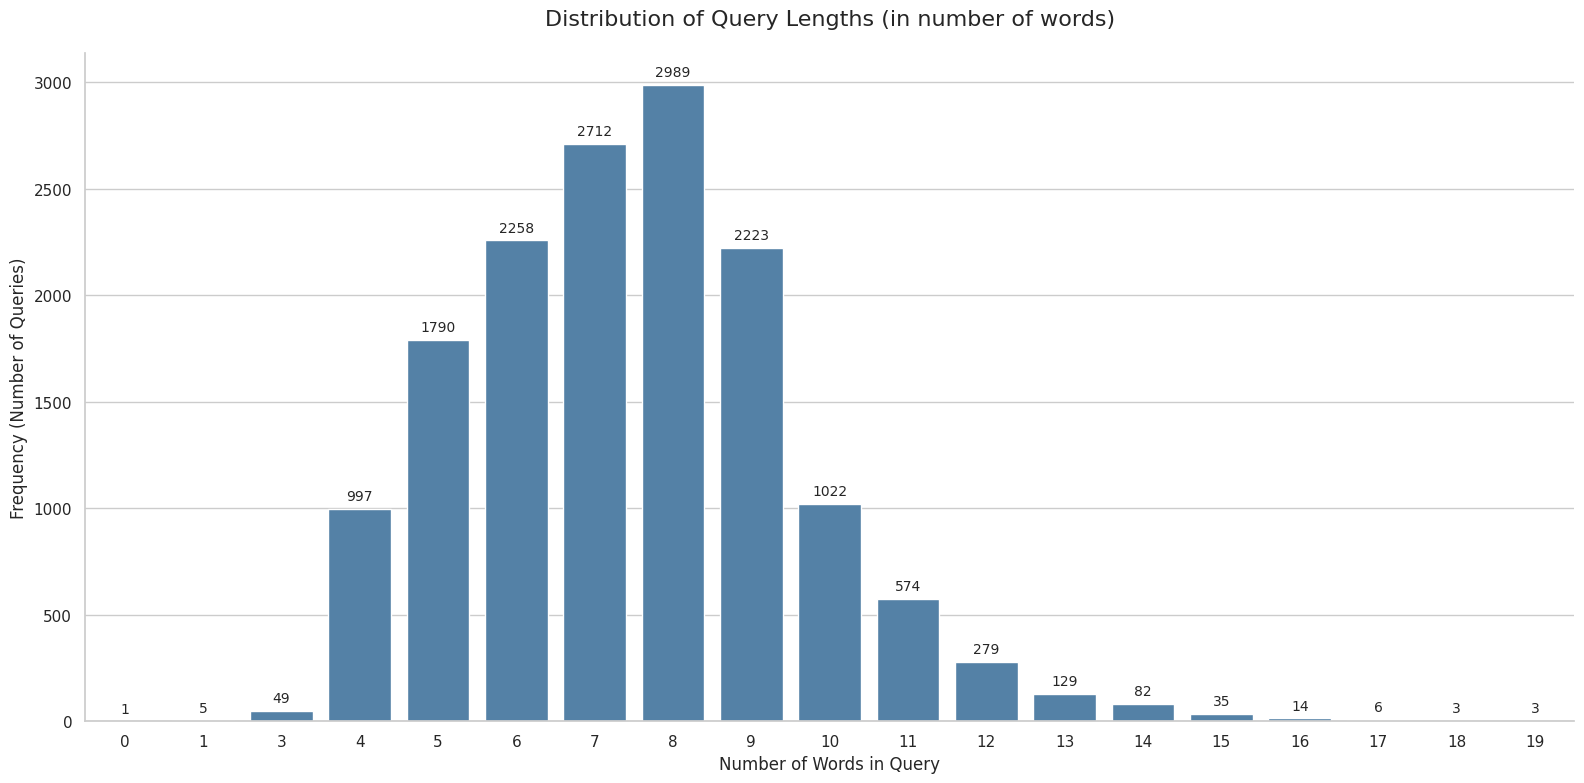

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure the DataFrame from the previous cells exists
if 'full_df' in locals():
    # Calculate the length of each query in words, if not already present
    if 'query_length' not in full_df.columns:
        full_df['query_length'] = full_df['query'].apply(lambda x: len(str(x).split()))

    # --- Plotting the distribution with a Bar Plot for clarity ---

    # 1. Calculate the frequency of each query length
    length_counts = full_df['query_length'].value_counts().sort_index()

    # 2. Create the bar plot
    plt.figure(figsize=(16, 8))
    ax = sns.barplot(
        x=length_counts.index,
        y=length_counts.values,
        color='steelblue'
    )

    # 3. Add numerical labels on top of each bar
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f'{int(p.get_height())}',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        xytext=(0, 9),
                        textcoords='offset points',
                        fontsize=10)

    # 4. Customize the plot for the final report
    ax.set_title('Distribution of Query Lengths (in number of words)', fontsize=16, pad=20)
    ax.set_xlabel('Number of Words in Query', fontsize=12)
    ax.set_ylabel('Frequency (Number of Queries)', fontsize=12)
    sns.despine()
    plt.tight_layout()
    plt.show()
else:
    print("ERROR: DataFrame 'full_df' not found. Please run the previous cells first.")